In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

import imgaug as ia
import imgaug.augmenters as iaa

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


In [2]:
classes = ['leve', 'fuerte']

base_dir=os.path.join( 'data_518')

train_dir = os.path.join(base_dir, 'train_leve_fuerte' )
val_dir  = os.path.join(base_dir,'val1_leve_fuerte')


In [3]:


train_0 = os.path.join(train_dir, 'leve') 
train_1 = os.path.join(train_dir, 'fuerte')

val_0 = os.path.join(val_dir, 'leve') 
val_1 = os.path.join(val_dir, 'fuerte')


#numeros
num_0_tr = len(os.listdir(train_0))
num_1_tr = len(os.listdir(train_1))


num_0_v = len(os.listdir(val_0))
num_1_v = len(os.listdir(val_1))


total_train = num_0_tr + num_1_tr 
total_val = num_0_v + num_1_v 
 

In [4]:
def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float64)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float64)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

In [5]:
def augment_pre(image):
    
    BRIGHTNESS_MIN_DELTA = 0.875
    BRIGHTNESS_MAX_DELTA = 1.125

    SATURATION_LOWER = 0.5
    SATURATION_UPPER = 1.5

    HUE_MIN_DELTA = 0.8
    HUE_MAX_DELTA = 1.2

    CONTRAST_LOWER = 0.5
    CONTRAST_UPPER = 1.5
    
    seq = iaa.Sequential([
        iaa.MultiplyBrightness((BRIGHTNESS_MIN_DELTA, BRIGHTNESS_MAX_DELTA)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5), 
        iaa.LinearContrast((CONTRAST_LOWER,CONTRAST_UPPER)),
        iaa.MultiplyHue((HUE_MIN_DELTA, HUE_MAX_DELTA)),
        iaa.MultiplySaturation((SATURATION_LOWER, SATURATION_UPPER)),

    ], random_order=True) # apply augmenters in random order
    image=image.astype(np.uint8)
    image=seq(image=image)

    image= rescale_min_1_to_1(image)
    
    return image

In [6]:
img_height=450
img_width=450
batch_size=32


In [7]:
image_gen_train = ImageDataGenerator(
      preprocessing_function=augment_pre
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(img_height,img_width),
                                                     class_mode='binary'
                                                     )

Found 30584 images belonging to 2 classes.


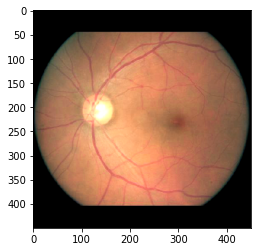

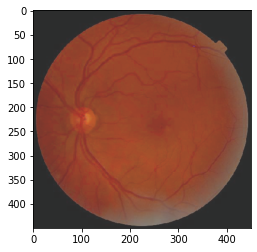

In [8]:

x,y = train_data_gen.next()

for i in range(0,2):
    image = x[i]
    plt.imshow((image+1)/2)
    plt.show()

In [9]:
image_gen_val = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 7646 images belonging to 2 classes.


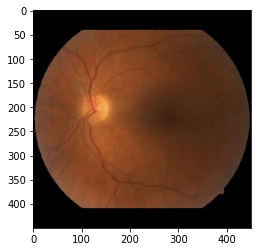

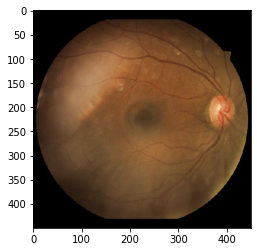

In [10]:

x,y = val_data_gen.next()

for i in range(0,2):
    image = x[i]
    plt.imshow((image+1)/2)
    plt.show()

In [11]:

with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(img_height,img_width,3), pooling='avg'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    



    model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=1e-4,decay=4e-6),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy',tf.keras.metrics.AUC()])

    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [12]:

checkpoint_filepath="weights//peso450x450_2.best.hdf5"

callbacks = [
    
    tf.keras.callbacks.EarlyStopping(
         monitor='val_loss', min_delta=0.0001 , patience=20, verbose=0, mode='min',
        baseline=None, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True),
]

In [13]:
with tf.device('/GPU:0'):
    epochs=2000
    history = model.fit(
        train_data_gen,
        steps_per_epoch=int(np.floor(total_train / float(batch_size))),
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=int(np.ceil(total_val / float(batch_size))),
        callbacks=callbacks,
    )

Epoch 1/2000
955/955 [==============================] - 878s 920ms/step - loss: 0.5297 - accuracy: 0.7933 - auc: 0.7919 - val_loss: 0.5140 - val_accuracy: 0.8390 - val_auc: 0.8114
Epoch 2/2000
955/955 [==============================] - 875s 916ms/step - loss: 0.5135 - accuracy: 0.8250 - auc: 0.8282 - val_loss: 0.5241 - val_accuracy: 0.8296 - val_auc: 0.7770
Epoch 3/2000
955/955 [==============================] - 876s 917ms/step - loss: 0.5092 - accuracy: 0.8312 - auc: 0.8372 - val_loss: 0.5012 - val_accuracy: 0.8622 - val_auc: 0.8372
Epoch 4/2000
955/955 [==============================] - 874s 916ms/step - loss: 0.5042 - accuracy: 0.8425 - auc: 0.8488 - val_loss: 0.5037 - val_accuracy: 0.8530 - val_auc: 0.8345
Epoch 5/2000
955/955 [==============================] - 874s 915ms/step - loss: 0.5002 - accuracy: 0.8512 - auc: 0.8537 - val_loss: 0.5109 - val_accuracy: 0.8499 - val_auc: 0.8056
Epoch 6/2000
955/955 [==============================] - 875s 916ms/step - loss: 0.4998 - accuracy: 0

955/955 [==============================] - 876s 918ms/step - loss: 0.4698 - accuracy: 0.9089 - auc: 0.9110 - val_loss: 0.4874 - val_accuracy: 0.8763 - val_auc: 0.8624
Epoch 47/2000
955/955 [==============================] - 877s 918ms/step - loss: 0.4692 - accuracy: 0.9107 - auc: 0.9124 - val_loss: 0.4850 - val_accuracy: 0.8803 - val_auc: 0.8773
Epoch 48/2000
955/955 [==============================] - 877s 918ms/step - loss: 0.4703 - accuracy: 0.9098 - auc: 0.9099 - val_loss: 0.4908 - val_accuracy: 0.8780 - val_auc: 0.8499


In [14]:
model.save('modelos//prueban450x450_2.h5')

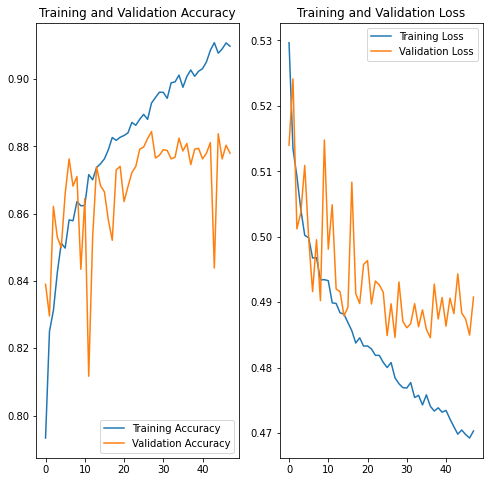

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
import math  
    
number_of_examples = len(val_data_gen.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

val_labels = []

for i in range(0,int(number_of_generator_calls)):
    val_labels.extend(np.array(val_data_gen[i][1]))

In [17]:
y_pred =  model.predict(val_data_gen, steps= int(np.ceil(total_val / float(batch_size))))

In [18]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve ( val_labels , y_pred)



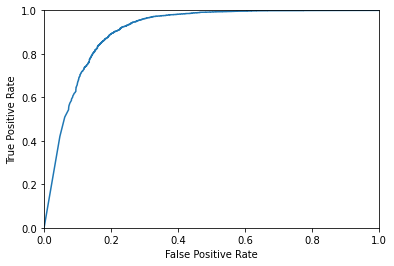

In [19]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 

In [20]:

def tpr_to_umbrales(tpr,fpr,thresholds,lista):
    umbrales=[]
    fprumb=[]
    
    for i in lista:
        umbrales.append(thresholds[(np.where(tpr>=i))[0][0]])
        fprumb.append(fpr[(np.where(tpr>=i))[0][0]])
    
    return (umbrales, fprumb)  

In [21]:
lista=[0.98,0.95,0.90,0.80]
  

umbrales , fprumb =tpr_to_umbrales(tpr,fpr,thresholds,lista)

for idx,i in enumerate(lista):
    print("tpr:"+str(i)+"->fpr: "+str(fprumb[idx])+" con umbral: "+str(umbrales[idx]))

tpr:0.98->fpr: 0.3814713896457766 con umbral: 0.00023166389
tpr:0.95->fpr: 0.27520435967302453 con umbral: 0.3036237
tpr:0.9->fpr: 0.20935513169845596 con umbral: 0.9839294
tpr:0.8->fpr: 0.14532243415077203 con umbral: 0.9998447
